## <center> **Анализ результатов A/B-тестирования**

Компания планирует запустить новую акцию, чтобы продать как можно больше туров. Команда разработала два варианта посадочной страницы официального сайта компании и провела A/B-тестирование. Собранные в результате проведения эксперимента данные вы можете найти здесь.

Вам предстоит решить настоящую бизнес-задачу: проанализировать эффективность обоих вариантов посадочной страницы сразу по двум критериям: конверсии покупки и среднему чеку. На основе проведенного анализа вам будет необходимо сделать выводы и принять решение: какой из вариантов дизайна более предпочтительный.

Итак, наша фирма предлагает следующие варианты туров и их соответствующие стоимости:
* Таиланд — 100000 рублей;
* Турция — 60000 рублей;
* Мальдивы — 200000 рублей;
* Санкт-Петербург — 10000 рублей;
* Камчатка — 150000 рублей.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy.stats import t
from scipy.stats import ttest_ind, shapiro, f_oneway, mannwhitneyu
from statsmodels.stats.proportion import proportions_ztest

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import set_config
set_config(transform_output = 'pandas')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

# sns.set_theme('notebook')
# sns.set_palette('Set2')

plt.rcParams['figure.figsize'] = (12, 8)

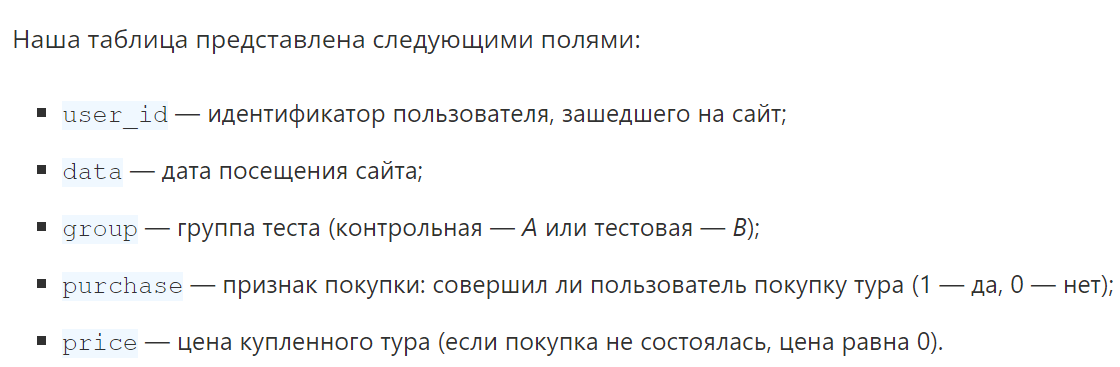

Прочитаем наши данные и посмотрим на столбцы таблицы:

In [3]:
data = pd.read_csv('data/ab_data_tourist.zip', parse_dates=['date'])
data.head()

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000


## **Задание 7.1.**

Начнем с исследования структуры наших данных. С помощью метода info() выведите информацию о типах данных и количестве непустых значений. Какой тип данных имеет столбец date?

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  object        
 3   purchase  294478 non-null  int64         
 4   price     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 11.2+ MB


## **Задание 7.2.**

Приведите столбец date к типу данных datetime. Убедитесь в равной длительности проведения тестирования для каждой из группы. Для этого сгруппируйте данные по признаку группы и определите первую и последнюю дату наблюдения для каждой из групп. 

В какой промежуток времени проводился A/B-тест?


In [5]:
# Конвертирую object к string в столбце group
data = data.convert_dtypes()

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   user_id   294478 non-null  Int64         
 1   date      294478 non-null  datetime64[ns]
 2   group     294478 non-null  string        
 3   purchase  294478 non-null  Int64         
 4   price     294478 non-null  Int64         
dtypes: Int64(3), datetime64[ns](1), string(1)
memory usage: 12.1 MB


In [7]:
data_a = data[data['group'] == 'A']
data_a.describe()

,user_id,date,purchase,price
count,147202.0,147202,147202.0,147202.0
mean,788123.098035,2021-01-13 01:55:49.470795520,0.120399,9757.068518
min,630002.0,2021-01-02 00:00:00,0.0,0.0
25%,709287.0,2021-01-08 00:00:00,0.0,0.0
50%,788053.5,2021-01-13 00:00:00,0.0,0.0
75%,867155.5,2021-01-19 00:00:00,0.0,0.0
max,945998.0,2021-01-24 00:00:00,1.0,200000.0
std,91278.896888,NaN,0.325429,34315.188601


In [8]:
data_b = data[data['group'] == 'B']
data_b.describe()

,user_id,date,purchase,price
count,147276.0,147276,147276.0,147276.0
mean,787825.226283,2021-01-13 01:23:47.034955008,0.11892,10552.296369
min,630000.0,2021-01-02 00:00:00,0.0,0.0
25%,708729.5,2021-01-08 00:00:00,0.0,0.0
50%,787837.5,2021-01-13 00:00:00,0.0,0.0
75%,866693.75,2021-01-19 00:00:00,0.0,0.0
max,945999.0,2021-01-24 00:00:00,1.0,200000.0
std,91142.800641,NaN,0.323695,35968.230971


Данные в группах собраны за один и тот же период

## **Задание 7.3.**

* Чему равно количество посещений сайта в группах А и B?

* Чему равно суммарное количество покупок в группах А и B?

* Чему равна сумма всех покупок в группах А и B? Ответ приведите в миллионах рублей. Например, 185.52 млн. руб.

In [9]:
agg_by_group = data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})
agg_by_group.columns = ['visit_count', 'purchase_count', 'purchase_sum']
agg_by_group['purchase_sum'] = agg_by_group['purchase_sum'] / 1_000_000
agg_by_group

,visit_count,purchase_count,purchase_sum
group,,,
A,147202,17723,1436.26
B,147276,17514,1554.1


## **Задание 7.4.**

Проверьте, есть ли пользователи, которые в процессе A/B-теста попали в обе тестовые группы? Если да, то сколько таких уникальных пользователей, если нет - введите в поле для ответа 0?

**Подсказка:**

*Создайте множество пользователей группы А и множество пользователей группы B. Пересеките два этих множества (операция intersection) и вычислите количество элементов в полученном множестве.*


In [10]:
set_a = set(data_a['user_id'].to_list())
set_b = set(data_b['user_id'].to_list())
user_intersection = set_a & set_b
print(f"Пользователей оказавшихся в обеих группах: {len(user_intersection)}")

Пользователей оказавшихся в обеих группах: 1895


## **Исключите пользователей, оказавшихся в обеих группах**

Так как мы не можем определить, какая из версий сайта повлияла на принятие решения, исключим этих пользователей. Далее мы будем работать только с очищенными от пересечений данными.

Возможный вариант исключения пользователей:

In [11]:
data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


In [12]:
# C помощью лямбды примененной к user_id создаю маску true/false которую передаю в датафрейм
updated_data = data[data['user_id'].apply(lambda x: x not in user_intersection)]

In [13]:
updated_data

,user_id,date,group,purchase,price
0,851104,2021-01-21,A,0,0
1,804228,2021-01-12,A,0,0
2,661590,2021-01-11,B,0,0
3,853541,2021-01-08,B,0,0
4,864975,2021-01-21,A,1,150000
...,...,...,...,...,...
294473,751197,2021-01-03,A,0,0
294474,945152,2021-01-12,A,0,0
294475,734608,2021-01-22,A,0,0
294476,697314,2021-01-15,A,0,0


Где user_intersection - множество пересечений пользователей групп А и B.

## **Задание 7.5.**

Для первичного анализа результатов A/B-тестирования нам понадобится таблица следующего вида:

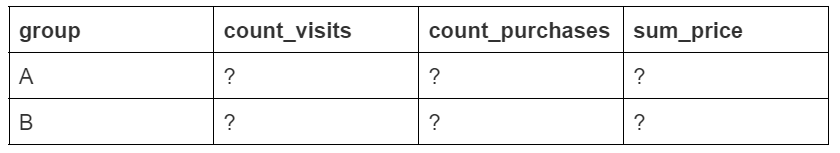
 
 
Для того, чтобы получить такую таблицу, сгруппируйте данные по признаку группы. В каждой группе рассчитайте следующие показатели:
* количество посещений (количество пользователей)
* количество совершенных покупок
* сумма всех покупок в группе

В полученной сгруппированной таблице переименуйте столбцы на **count_visits, count_purchases и sum_price**.

**Подсказка:**

*Для переименования столбцов можно использовать метод rename() с параметром columns, в который передается словарь. Ключи этого словаря - старые имена столбцов, а значения - новые.*

Чему на этот раз равно количество посещений сайта в группах А и B?


In [14]:
group_ab = updated_data.groupby('group').agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})
group_ab.columns = ['count_visits', 'count_purchase', 'sum_price']
group_ab

,count_visits,count_purchase,sum_price
group,,,
A,145307,17487,1417780000
B,145381,17290,1533010000


Приведите промежуточные выводы по построенной таблице. Сопоставимо ли количество посещений обоих вариантов посадочной странице, можно ли говорить о сбалансированности выборок?

In [15]:
share_a = group_ab['count_visits'].iloc[0] / group_ab['count_visits'].sum() * 100
print(f"Доля группы A во всей выборке составляет: {share_a:.2f} %")

Доля группы A во всей выборке составляет: 49.99 %


Группы практически идеально сбалансированны

## **Задание 7.6.**

Добавьте в сгруппированную таблицу столбцы conversion - конверсия покупки (отношение количества покупок к количеству посещений сайта в каждой группе, выраженное в процентах) и mean_check - средний чек (отношение суммы покупок к количеству покупок в каждой группе).

* Чему равна конверсия в группах? Ответ приведите в процентах и округлите до сотых. Например, 75.12 %
* Чему равен средний чек в группах? Ответ приведите в рублях и округлите до целых. Например, 120519 рублей.

In [16]:
group_ab['conversion'] = (group_ab['count_purchase'] / group_ab['count_visits'] * 100).round(2)
group_ab['mean_check'] = (group_ab['sum_price'] / group_ab['count_purchase']).round()
group_ab

,count_visits,count_purchase,sum_price,conversion,mean_check
group,,,,,
A,145307,17487,1417780000,12.03,81076.0
B,145381,17290,1533010000,11.89,88665.0


Приведите промежуточные выводы по таблице. По какому(им) показателю(ям) вариант А эффективнее варианта B и наоборот?

По конверсии A лучше B.

По среднему чеку наоборот B лучше A. И суммарная выручка выше у варианта B.

Т.е. пока, предварительно вариант B лучше.

## **Задание 7.7.**

Теперь давайте сравним варианты по покупательской способности туров. Для этого постройте сводную таблицу, которая покажет зависимость количества продаж от группы и цены тура. 

Визуализируйте полученную сводную таблицу с помощью тепловой карты с аннотацией. 
Чему равно количество проданных туров за 60000 рублей в группах?

In [17]:
pivot = updated_data.pivot_table(index='group', columns='price', values='user_id', aggfunc='count')

# Убираю столбец c нулевой ценой, там же конверсии нет, смотреть на него не интересно
pivot.drop(columns=[0], inplace=True)
pivot = pivot[pivot.columns[1:]]

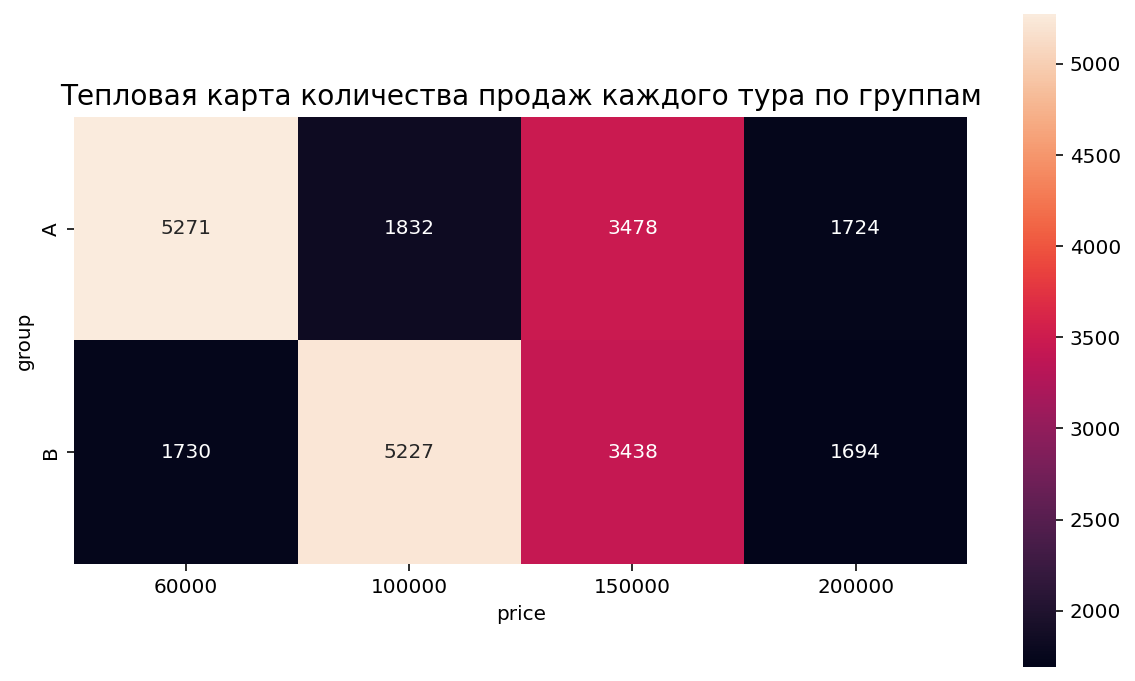

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(pivot, annot=True, fmt='g', cbar=True, square=True);
ax.set_title('Тепловая карта количества продаж каждого тура по группам', size=14);

Сделайте выводы по построенной таблице. По каким турам покупательская способность участников группы А выше, чем участников группы B и наоборот?

По турам в 60т сильно больше продаж для группы A. Так же совсем немного больше продаж по турам в 200т для группы A.

По группе B сильнейший рост в турах по 100т.

## **Задание 7.8.**

Настало время поговорить о стабилизации кумулятивных метрик во времени. Но прежде, чем перейти к кумулятивным метрикам, нам необходимо построить таблицу с ежедневными данными результатов проведения A/B-тестирования.

Сгруппируйте данные по дате и группе тестирования. В каждой группе вычислите количество посещений страницы, количество покупок и сумму покупок. 

Добавьте в таблицу информацию о ежедневной конверсии (ежедневное количество покупок / ежедневное количество посещений) в группе и ежедневном среднем чеке (ежедневная сумма покупок / ежедневное количество покупок)
* Чему равна конверсия 3 января 2021 года? Ответ приведите в процентах и округлите до сотых.

* Чему равен средний чек 3 января 2021 года? Ответ приведите в рублях и округлите до целого.

In [87]:
daily_group = updated_data.groupby(['date', 'group']).agg({'user_id': 'count', 'purchase': 'sum', 'price': 'sum'})
daily_group.reset_index(inplace=True)
daily_group.rename(columns={'user_id': 'count_visits', 'purchase': 'count_purchase', 'price': 'sum_purchase'}, inplace=True)
daily_group['conversion'] = (daily_group['count_purchase'] / daily_group['count_visits'] * 100).round(2)
daily_group['receipt'] = (daily_group['sum_purchase'] / daily_group['count_purchase']).round(0).astype('int')
daily_group

,date,group,count_visits,count_purchase,sum_purchase,conversion,receipt
0,2021-01-02,A,2854,359,29410000,12.58,81922
1,2021-01-02,B,2861,345,29660000,12.06,85971
2,2021-01-03,A,6596,748,62000000,11.34,82888
3,2021-01-03,B,6619,754,65960000,11.39,87480
4,2021-01-04,A,6566,799,64250000,12.17,80413
5,2021-01-04,B,6536,764,68030000,11.69,89045
6,2021-01-05,A,6433,790,64550000,12.28,81709
7,2021-01-05,B,6511,749,63550000,11.5,84846
8,2021-01-06,A,6606,764,63410000,11.57,82997
9,2021-01-06,B,6751,838,75020000,12.41,89523


## **Задание 7.9.** 

Добавьте в таблицу с ежедневными показателями кумулятивные признаки:
* кумулятивное количество посещений страницы
* кумулятивное количество покупок
* кумулятивную сумму покупок

Не забудьте при расчете кумулятивной суммы сгруппировать данные по группам. 

Вычислите кумулятивную конверсию и кумулятивный средний чек на основе полученных кумулятивных показателей. 

* Какая **кумулятивная** конверсия была в группе B на 20 января? Ответ приведите в процентах, округлив до сотых.
* Какой **кумулятивный** средний чек был в группе А на 12 января 2021 года? Ответ приведите в рублях, округлив до целых.

In [88]:
daily_group['cum_visits'] = daily_group.groupby('group')['count_visits'].cumsum()
daily_group['cum_purchase'] = daily_group.groupby('group')['count_purchase'].cumsum()
daily_group['cum_sum'] = daily_group.groupby('group')['sum_purchase'].cumsum()

daily_group['cum_conversion'] = (daily_group['cum_purchase'] / daily_group['cum_visits'] * 100).round(2)
daily_group['cum_receipt'] = (daily_group['cum_sum'] / daily_group['cum_purchase']).round().astype('int')
daily_group

,date,group,count_visits,count_purchase,sum_purchase,conversion,receipt,cum_visits,cum_purchase,cum_sum,cum_conversion,cum_receipt
0,2021-01-02,A,2854,359,29410000,12.58,81922,2854,359,29410000,12.58,81922
1,2021-01-02,B,2861,345,29660000,12.06,85971,2861,345,29660000,12.06,85971
2,2021-01-03,A,6596,748,62000000,11.34,82888,9450,1107,91410000,11.71,82575
3,2021-01-03,B,6619,754,65960000,11.39,87480,9480,1099,95620000,11.59,87006
4,2021-01-04,A,6566,799,64250000,12.17,80413,16016,1906,155660000,11.9,81668
5,2021-01-04,B,6536,764,68030000,11.69,89045,16016,1863,163650000,11.63,87842
6,2021-01-05,A,6433,790,64550000,12.28,81709,22449,2696,220210000,12.01,81680
7,2021-01-05,B,6511,749,63550000,11.5,84846,22527,2612,227200000,11.59,86983
8,2021-01-06,A,6606,764,63410000,11.57,82997,29055,3460,283620000,11.91,81971
9,2021-01-06,B,6751,838,75020000,12.41,89523,29278,3450,302220000,11.78,87600


Постройте кумулятивные графики конверсии и среднего чека в каждой группе по дням. Сделайте выводы. Можно ли назвать A/B-тест завершенным - стабилизировались ли значения метрик во времени? Как соотносятся кумулятивные показатели в каждой группе?

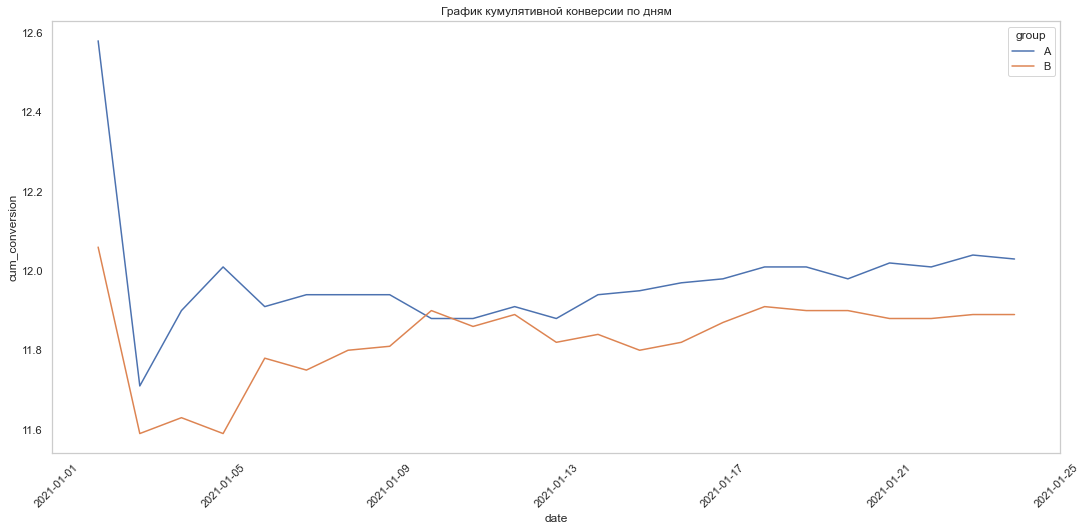

In [89]:
# создаём фигуру размером
fig = plt.figure(figsize=(14, 6))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_group,
    x='date',
    y='cum_conversion',
    hue='group',
    ax=ax
)
# задаём подпись к графику
ax.set_title('График кумулятивной конверсии по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

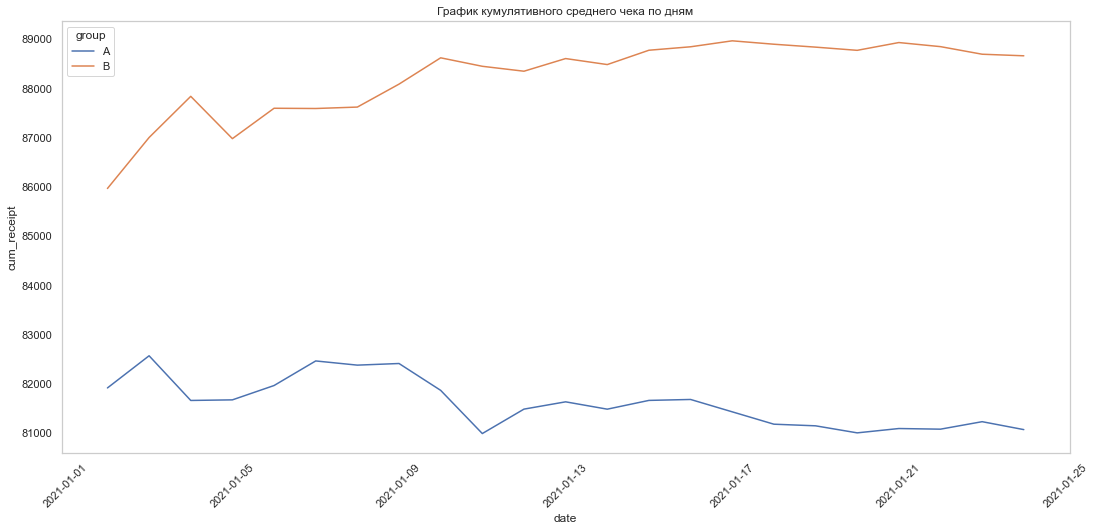

In [90]:
# создаём фигуру размером
fig = plt.figure(figsize=(14, 6))
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1])
# строим lineplot для конверсии во времени в каждой группе
sns.lineplot(
    data=daily_group,
    x='date',
    y='cum_receipt',
    hue='group',
    ax=ax
)
# задаём подпись к графику
ax.set_title('График кумулятивного среднего чека по дням')
# задаём поворот меток на оси абсцисс
ax.xaxis.set_tick_params(rotation=45)
# задаём отображение сетки
ax.grid();

Кумулятивные метрики стабилизировались, данных достаточно для завершения тестирования.

Кумулятивная конверсия почти всю продолжительность теста выше для группы A, только на одном дне корверсия B больше А.

Кумулятивный средний чек на всей продолжительности теста выше для группы B.

## **Задание 7.10.**

Настало время переходить к проверке статистической значимости разницы между метриками в группах. Начнем с конверсии.

Какой тест вы примените для проверки гипотезы о равенстве конверсий в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Конверсии в группах А и B равны; 
* $H_1$: Конверсия в группе А больше чем конверсия в группе B;

Вычислите p-value вашего теста для конверсий в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$=0.05. 

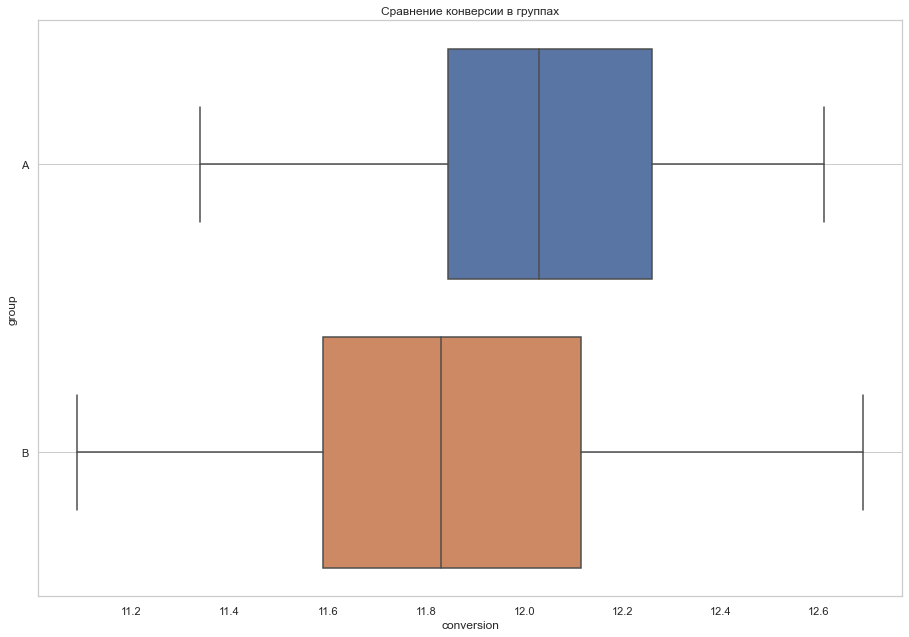

In [91]:
# создаём фигуру
fig = plt.figure(figsize=(12, 8)) 
# добавляем систему координат
ax = fig.add_axes([1, 1, 1, 1]) 
# строим boxplot для conversion по признаку group
sns.boxplot(data=daily_group, x='conversion', y='group', ax=ax) 
# задаём подпись к графику
ax.set_title('Сравнение конверсии в группах')
# задаём отображение сетки
ax.grid()
sns.set_style('whitegrid')

Визуально конверсия в группе А выше чем в группе B. Так же разброс у группы A ниже.

Средний и медианный показатель конверсий по группами

In [92]:
conversion_piv = daily_group.groupby('group')['conversion'].agg(['mean', 'median'])
conversion_piv

,mean,median
group,,
A,12.043478,12.03
B,11.896957,11.83


In [93]:
# Cгруппируем исходные данные по признаку группы и рассчитаем количество продаж и общее количество переходов для каждой группы
converted_piv = updated_data.groupby('group')['purchase'].agg(['sum', 'count'])
converted_piv

,sum,count
group,,
A,17487,145307
B,17290,145381


In [94]:
from statsmodels.stats.proportion import proportions_ztest

# нулевая и альтернативная гипотезы
H0 = 'Конверсии в группах А и B равны'
H1 = 'Конверсия в группе А выше, чем конверсия в группе B'
alpha = 0.05 # уровень значимости

# вычисляем значение p-value для z-теста для пропорций
_, p_value = proportions_ztest(
    count=converted_piv['sum'], # число покупок
    nobs=converted_piv['count'], # общее число переходов
    alternative='larger'
    )

# выводим результат на экран
print(f'p-value: {round(p_value, 2)}')

# сравниваем полученное p-value с уровнем значимости
if (p_value < alpha): 
    print(f"Отвергаем нулевую гипотезу. {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value: 0.12
Принимаем нулевую гипотезу. Конверсии в группах А и B равны


Приведите свои выводы по результатам проведенного статистического теста. Есть ли статистическая разница между конверсиями в группах А и B?

p-value = 0.12 и больше alpha = 0.05
Принимаем нулевую гипотезу. Конверсии в группах А и B равны. Статистическая разница конверсии в группах отсутствует.

## **Задание 7.11.**
Убедитесь в своих рассуждениях, построив 95%-ый доверительный интервал для конверсий и разницы между ними. Используйте $z_{крит}$ в своих расчетах

Укажите нижнюю и верхнюю границы доверительных интервалов. Границы приведите в процентах и округлите до 2 знака после запятой. Например: нижняя граница 89.24%, верхняя граница 91.25%.

In [95]:
def proportions_confidence_interval(n, x_p, gamma=0.95):
    """
    Функция расчета доверительного интервала для конверсий.
    Конверсия - доля пользователей совершивших целевое действие.

    :param n: Размер выборки
    :param x_p: Выборочная пропорция или конверсия
    :param gamma: Уровень надежности
    :return: Возвращает кортеж из границ доверительного интервала
    """

    alpha = 1 - gamma  # уровень значимости
    z_crit = -norm.ppf(alpha / 2)  # z критическое
    eps = z_crit * (x_p * (1 - x_p) / n) ** 0.5  # погрешность
    lower_bound = x_p - eps  # левая (нижняя) граница
    upper_bound = x_p + eps  # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [96]:
group_name = 'A'
data_a = updated_data[updated_data['group'] == group_name]
n = data_a.shape[0]
x_p = data_a['purchase'].mean()
gamma = 0.95

interval = proportions_confidence_interval(n, x_p, gamma)
f'Доверительный интервал конверсии для группы {group_name} составляет {interval}, с вероятностью {gamma * 100:.0f}%'

'Доверительный интервал конверсии для группы A составляет (11.87, 12.2), с вероятностью 95%'

In [97]:
group_name = 'B'
data_a = updated_data[updated_data['group'] == group_name]
n = data_a.shape[0]
x_p = data_a['purchase'].mean()
gamma = 0.95

interval = proportions_confidence_interval(n, x_p, gamma)
f'Доверительный интервал конверсии для группы {group_name} составляет {interval}, с вероятностью {gamma * 100:.0f}%'

'Доверительный интервал конверсии для группы B составляет (11.73, 12.06), с вероятностью 95%'

In [98]:
def diff_proportions_confidence_interval(n, xp, gamma=0.95):
    """
    Функция для расчета доверительного интервала разницы конверсий

    :param n: Список размеров выборки для варианта A и B
    :param xp: Список выборочных пропорция или конверсий для варианта A и B
    :param gamma: Уровень надежности
    :return: Возвращает кортеж из границ доверительного интервала
    """

    alpha = 1 - gamma  # уровень значимости
    diff = xp[1] - xp[0]  # выборочная разница конверсий групп B и A
    z_crit = -norm.ppf(alpha / 2)  # z критическое
    eps = z_crit * (xp[0] * (1 - xp[0]) / n[0] + xp[1] * (1 - xp[1]) / n[1]) ** 0.5  # погрешность
    lower_bound = diff - eps  # левая (нижняя) граница
    upper_bound = diff + eps  # правая (верхняя) граница
    # возвращаем кортеж из округлённых границ интервала
    return round(lower_bound * 100, 2), round(upper_bound * 100, 2)

In [99]:
# Сделаю группировку для получения данных для расчета разницы конверсий
n_and_x_by_group = updated_data.groupby('group').agg({'user_id': 'count', 'purchase': 'mean'})
# переименую столбцы
n_and_x_by_group.columns = ['n', 'x']
n_and_x_by_group

,n,x
group,,
A,145307,0.120345
B,145381,0.118929


In [100]:
n = n_and_x_by_group['n'].to_list()
xp = n_and_x_by_group['x'].to_list()
gamma = 0.95
diff_interval = diff_proportions_confidence_interval(n, xp, gamma)

f'Доверительный интервал разницы конверсии двух групп составляет {diff_interval}, с вероятностью {gamma * 100:.0f}%'

'Доверительный интервал разницы конверсии двух групп составляет (-0.38, 0.09), с вероятностью 95%'

Проинтерпретируйте построенные доверительные интервалы для конверсий в группах. Есть ли перекрытие между доверительными интервалами для групп? Есть ли статистическая разница между конверсиями в группах А и B?

Доверительные интервалы пересекаются. 

Это говорит о том что истинное значение конверсий в двух группах могут совпадать.

Разница между доверительными интрвалами групп охватывает 0, значит со статисчитеской значимостью в 95% можно сказать о равнозначности групп по метрике конверсии.

## **Задание 7.12.**

Ранее мы построили таблицу с ежедневными показателями. Теперь она нам снова понадобится, так как нас интересует ежедневный средний чек.

Проверьте гипотезу о нормальности распределения ежедневного среднего чека в каждой из групп тестирования. 

* Какой тест вы примените  для проверки гипотезы о нормальности распределения ежедневного среднего чека?
* Как будут звучать нулевая и альтернативная гипотезы?
* Каковы результаты статистического теста с уровнем значимости $\alpha$ =0.05?

In [107]:
daily_group.head()

,date,group,count_visits,count_purchase,sum_purchase,conversion,receipt,cum_visits,cum_purchase,cum_sum,cum_conversion,cum_receipt
0,2021-01-02,A,2854,359,29410000,12.58,81922,2854,359,29410000,12.58,81922
1,2021-01-02,B,2861,345,29660000,12.06,85971,2861,345,29660000,12.06,85971
2,2021-01-03,A,6596,748,62000000,11.34,82888,9450,1107,91410000,11.71,82575
3,2021-01-03,B,6619,754,65960000,11.39,87480,9480,1099,95620000,11.59,87006
4,2021-01-04,A,6566,799,64250000,12.17,80413,16016,1906,155660000,11.9,81668


In [119]:
# Сделаю сводную таблицу со столбцами названиями групп и данными средних чеков по дням
daily_receipt_by_group = daily_group.pivot_table(index='date', values='receipt', columns='group')


(23, 2)

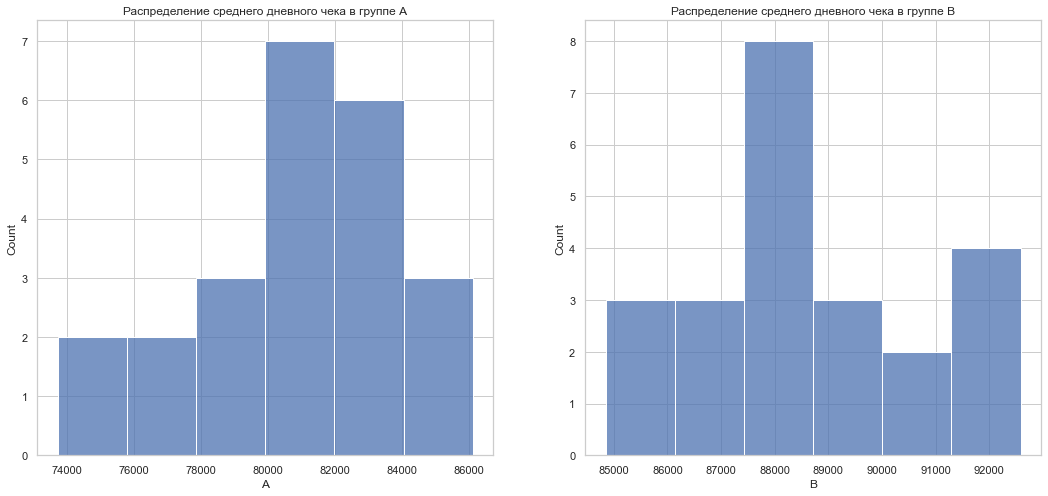

In [109]:
# Посмотрим на графики распределения средних дневных чеков для каждой из групп
fig, axes = plt.subplots(1, 2, figsize=(18, 8))
#строим гистограмму для средних дневных чеков
sns.histplot(x='A', data=daily_receipt_by_group, ax=axes[0])
sns.histplot(x='B', data=daily_receipt_by_group, ax=axes[1])
#задаём названия графикам
axes[0].set_title('Распределение среднего дневного чека в группе А');
axes[1].set_title('Распределение среднего дневного чека в группе B');

Визуально распределения в обоих группах напоминают нормальное

In [115]:
# нулевая и альтернативная гипотезы
H0 = 'Распределения среднего дневного чека в обеих группах нормальные.'
Ha = 'Распределение среднего дневного чека в одной или обеих группах отлично от нормального.'
alpha = 0.05 # уровень значимости

# вычисляем результат теста Шапиро-Уилка для выборок
shapiro_result_a = shapiro(daily_receipt_by_group['A'])
shapiro_result_b = shapiro(daily_receipt_by_group['B'])

print('p-value группы А:', round(shapiro_result_a.pvalue, 2))
print('p-value группы B:', round(shapiro_result_b.pvalue, 2))

# сравниваем полученное p-value с уровнем значимости
if shapiro_result_a.pvalue < alpha or shapiro_result_b.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу. {H0}")
    print(f"Альтернативная гипотеза. Ha: {Ha}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value группы А: 0.25
p-value группы B: 0.09
Принимаем нулевую гипотезу. Распределения среднего дневного чека в обеих группах нормальные.


## **Задание 7.13.**
Настало время сравнить варианты дизайна страницы по метрике среднего чека. 

Какой тест вы примените для проверки гипотезы о равенстве средних чеков по дням в группах?

Проведите тестирование при следующих нулевой и альтернативной гипотезе:
* $H_0$: Ежедневные средние чеки в группах А и B равны; 
* $H_1$: Ежедневный средний чек в группе А меньше чем в группе B;

Вычислите p-value вашего теста для ежедневного среднего чека в группах А и B. Сравните полученное значение p-value с уровнем значимости $\alpha$ =0.05. 

In [122]:
# нулевая и альтернативная гипотезы
H0 = 'Ежедневные средние чеки в группах А и B равны.'
H1 = 'Ежедневный средний чек в группе А меньше чем в группе B.'
alpha = 0.05 # уровень значимости

#вычисляем результат T-теста для выборок
results = ttest_ind(
    a=daily_receipt_by_group['A'],
    b=daily_receipt_by_group['B'],
    alternative='less'
)
print('p-value:', round(results.pvalue, 2))
 
if results.pvalue < alpha:
    print(f"Отвергаем нулевую гипотезу. {H0}")
    print(f"Альтернативная гипотеза. H1: {H1}")
else:
    print(f"Принимаем нулевую гипотезу. {H0}")

p-value: 0.0
Отвергаем нулевую гипотезу. Ежедневные средние чеки в группах А и B равны.
Альтернативная гипотеза. H1: Ежедневный средний чек в группе А меньше чем в группе B.


 Приведите свои выводы по проведенному статистическому тесту. Есть ли статистическая разница между ежедневными средними чеками в группах А и B?

Согласно t-тесту ежедневный средний чек в группе А меньше чем в группе B.

## **Задание 7.14.**

Постройте 95%-ый доверительный интервал для среднего чека в каждой группе. Так как выборка средних чеков небольшая, используйте  $t_{крит}$ в своих расчетах.

Укажите нижнюю границу доверительного интервала для истинного среднего чека каждой из групп. Ответ приведите в процентах и округлите до целого.

In [146]:
def confidence_interval(n, x_mean, x_std, gamma=0.95, round_bound = 0):
    """
    Функци для расчета доверительного интервала, когда известно выборочное стандартное отклонение

    :param n: Количество элементов в выборке
    :param x_mean: Выборочное среднее
    :param x_std: Выборочное стандартное отклонение
    :param gamma: Уровень надежности
    :return: Возвращает кортеж границ доверительного интервала
    """

    alpha = 1 - gamma
    k = n - 1
    t_crit = -t.ppf(alpha / 2, k)  # t-критическое
    eps = t_crit * x_std / (n ** 0.5)  # погрешность
    lower_bound = x_mean - eps  # левая (нижняя) граница
    upper_bound = x_mean + eps  # правая (верхняя) граница

    return round(lower_bound, round_bound), round(upper_bound, round_bound)

In [147]:
daily_group.head()

,date,group,count_visits,count_purchase,sum_purchase,conversion,receipt,cum_visits,cum_purchase,cum_sum,cum_conversion,cum_receipt
0,2021-01-02,A,2854,359,29410000,12.58,81922,2854,359,29410000,12.58,81922
1,2021-01-02,B,2861,345,29660000,12.06,85971,2861,345,29660000,12.06,85971
2,2021-01-03,A,6596,748,62000000,11.34,82888,9450,1107,91410000,11.71,82575
3,2021-01-03,B,6619,754,65960000,11.39,87480,9480,1099,95620000,11.59,87006
4,2021-01-04,A,6566,799,64250000,12.17,80413,16016,1906,155660000,11.9,81668


In [153]:
group_name = 'A'
daily_a = daily_group[daily_group['group'] == group_name]

n = daily_a.shape[0]
x_mean = daily_a['receipt'].mean()
x_std = daily_a['receipt'].std()

ci = confidence_interval(n, x_mean, x_std)
print(f'Доверительный интервал среднего дневного чека для группы {group_name} {ci}')

Доверительный интервал среднего дневного чека для группы A (79630.0, 82308.0)


In [154]:
group_name = 'B'
daily_a = daily_group[daily_group['group'] == group_name]

n = daily_a.shape[0]
x_mean = daily_a['receipt'].mean()
x_std = daily_a['receipt'].std()

ci = confidence_interval(n, x_mean, x_std)
print(f'Доверительный интервал среднего дневного чека для группы {group_name} {ci}')

Доверительный интервал среднего дневного чека для группы B (87626.0, 89526.0)


Проинтерпретируйте построенные доверительные интервалы для ежедневных средних чеков в группах. Есть ли между ними пересечения?

Доверительный интервал среднего чека для группы B больше чем A. 

Интервалы не пересекаются, что говорит о статистической значимости превышения среднего чека B над А.

## **Сделайте общий вывод по результатам A/B-теста**

Какой варианта дизайна посадочной страницы является более эффективным в комплексе по метрикам конверсии и среднего чека и почему? 

В комплексе по двум метрикам нужно выбирать вариант B. 

По метрике конверсии статистически группы одинаковы.

А по показателю среднего чека у группы B средний чек больше, что подтверждено статистически с заданным уровнем значимости в 5%